In [2]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
from fastcore.xtras import Path
import re

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers

In [3]:
path_imgs = Path("Images/Wally_desp")

In [4]:
def get_coords_from_path(path):
    x, y = re.search("img_(\d+)_(\d+)", str(path)).groups()
    return int(x), int(y)

In [5]:
IMG_SIZE = (128,128)
TEST_SIZE = 0.3
SEED = 42

In [6]:
paths = list(path_imgs.glob("*.jpg"))
paths_train, paths_test = train_test_split(paths, test_size=TEST_SIZE, random_state=SEED)
len(paths), len(paths_train), len(paths_test)

(5880, 4116, 1764)

In [7]:
def dataset_train():
    for path in paths_train:
        path = str(path)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0
        x, y = get_coords_from_path(path)
        label = np.array([x,y])/float(img.shape[0])
        img = cv2.resize(img, dsize=IMG_SIZE)
        yield img, label

In [8]:
def dataset_test():
    for path in paths_test:
        path = str(path)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0
        x, y = get_coords_from_path(path)
        label = np.array([x,y])/float(img.shape[0])
        img = cv2.resize(img, dsize=IMG_SIZE)
        yield img, label

In [9]:
dst_train = tf.data.Dataset.from_generator(dataset_train,
                                           output_signature=(
                                            tf.TensorSpec(shape=(*IMG_SIZE,3), dtype=tf.float32),
                                            tf.TensorSpec(shape=(2,), dtype=tf.float32)
                                           ))

2023-03-13 18:05:11.257957: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-13 18:05:11.258048: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mlui01.ific.uv.es
2023-03-13 18:05:11.258099: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mlui01.ific.uv.es
2023-03-13 18:05:11.258335: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.85.12
2023-03-13 18:05:11.258754: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.85.12
2023-03-13 18:05:11.258774: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.85.12
2023-03-13 18:05:11.260567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

In [10]:
dst_test = tf.data.Dataset.from_generator(dataset_test,
                                           output_signature=(
                                            tf.TensorSpec(shape=(*IMG_SIZE,3), dtype=tf.float32),
                                            tf.TensorSpec(shape=(2,), dtype=tf.float32)
                                           ))

In [11]:
for img, label in dst_train:
    break
img.shape, label

(TensorShape([128, 128, 3]),
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.484, 0.48 ], dtype=float32)>)

In [12]:
def plot_img_dot(img, dot_xy, show=True):
    dot_xy *= img.shape[0]
    plt.imshow(img)
    plt.plot(*dot_xy, 'or')
    if show: plt.show()

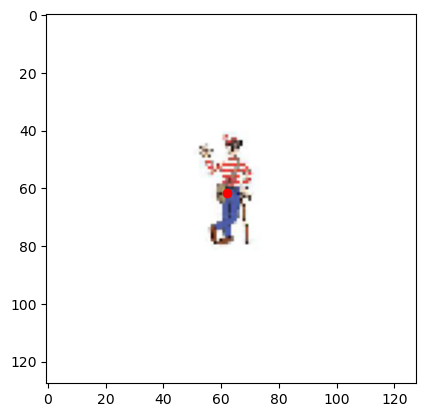

In [13]:
plot_img_dot(img, label)

In [15]:
model = tf.keras.Sequential([
    layers.Conv2D(32, 5, activation="relu", input_shape=(128,128,3)),
    layers.MaxPool2D(2),
    layers.Conv2D(64, 5, activation="relu"),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(2, activation="sigmoid")
])

In [16]:
history = model.fit(dst_train.batch(32),
                    epochs=10,
                    validation_data=dst_train.batch(64)
                    )

Epoch 1/10
129/129 [==============================] - 48s 368ms/step - loss: 0.0056 - mae: 0.0449 - val_loss: 3.1254e-04 - val_mae: 0.0138
Epoch 2/10
129/129 [==============================] - 47s 367ms/step - loss: 2.0318e-04 - mae: 0.0108 - val_loss: 1.9612e-04 - val_mae: 0.0110
Epoch 3/10
129/129 [==============================] - 46s 356ms/step - loss: 9.9134e-05 - mae: 0.0076 - val_loss: 9.3221e-05 - val_mae: 0.0078
Epoch 4/10
129/129 [==============================] - 46s 355ms/step - loss: 1.6097e-04 - mae: 0.0093 - val_loss: 1.7559e-04 - val_mae: 0.0105
Epoch 5/10
129/129 [==============================] - 48s 377ms/step - loss: 1.1745e-04 - mae: 0.0085 - val_loss: 1.1479e-04 - val_mae: 0.0080
Epoch 6/10
129/129 [==============================] - 49s 379ms/step - loss: 5.7039e-05 - mae: 0.0058 - val_loss: 6.1600e-05 - val_mae: 0.0063
Epoch 7/10
129/129 [==============================] - 48s 371ms/step - loss: 3.6869e-05 - mae: 0.0047 - val_loss: 4.8310e-05 - val_mae: 0.0055
Epo

In [16]:
# Recrea exactamente el mismo modelo solo desde el archivo
model.load_weights('wally_small.h5')

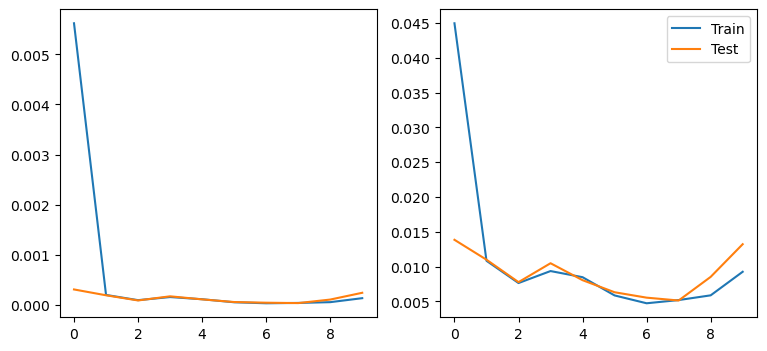

In [17]:
fig, axes = plt.subplots(1,2,figsize=(9,4))
axes[0].plot(history.history["loss"], label="Train")
axes[0].plot(history.history["val_loss"], label="Test")
axes[1].plot(history.history["mae"], label="Train")
axes[1].plot(history.history["val_mae"], label="Test")
plt.legend()
plt.show()

1/1 [==============================] - 0s 33ms/step


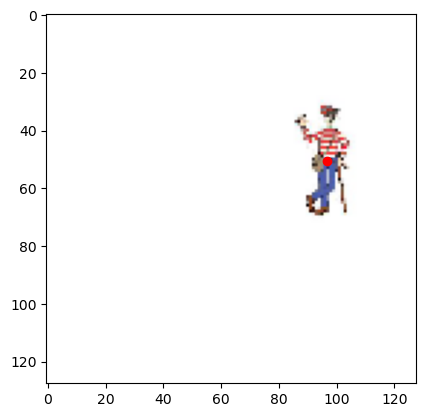

1/1 [==============================] - 0s 30ms/step


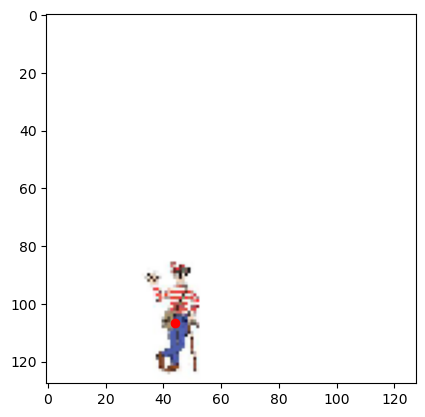

1/1 [==============================] - 0s 23ms/step


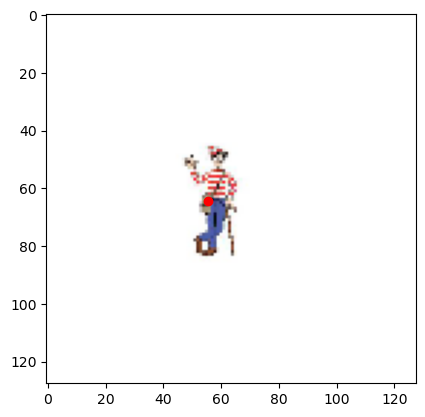

1/1 [==============================] - 0s 31ms/step


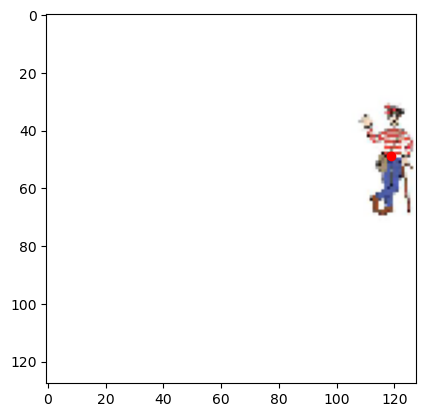

1/1 [==============================] - 0s 23ms/step


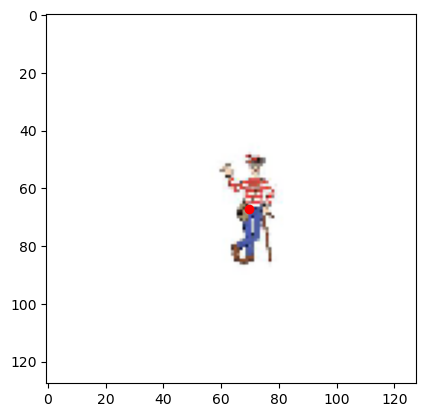

In [20]:
for img, label in dst_test.take(5):
    pred = model.predict(img[None,:])
    plot_img_dot(img, pred[0])
    
#plot_img_dot(img, label)

In [20]:
# model.save_weights("wally_big.h5")